In [1]:
import sys
sys.path.append('../edaf')

In [2]:
from plot_helpers import *
from decomp import *
from sortedcontainers import SortedList, SortedDict
from loguru import logger
import os, sys, gzip, json
import sqlite3
import pandas as pd
from edaf.core.uplink.preprocess import preprocess_ul
from edaf.core.uplink.analyze_packet import ULPacketAnalyzer
from edaf.core.uplink.analyze_channel import ULChannelAnalyzer
from edaf.core.uplink.analyze_scheduling import ULSchedulingAnalyzer
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import JSON

from pathlib import Path
import ijson

%load_ext autoreload
%autoreload 2

In [3]:
# Remove default handler
logger.remove()
# Add a new handler with level WARNING
logger.add(sys.stdout, level="ERROR")

16

In [5]:
MEAS_DIR = '../meas-oai5g/'
MEAS_LABEL = 's33'
DB_FILE = MEAS_DIR+MEAS_LABEL+'/'+'res_db.sql'
PLOTS_DIR = './plots/'+MEAS_LABEL+'/'

In [5]:
# packet analyzer
analyzer = ULPacketAnalyzer(DB_FILE)
uids_arr = range(analyzer.first_ueipid, analyzer.last_ueipid+1)
packets = analyzer.figure_packettx_from_ueipids(uids_arr)

# sched analyzer
sched_analyzer = ULSchedulingAnalyzer(
    total_prbs_num = 106, 
    symbols_per_slot = 14, 
    slots_per_frame = 20, 
    slots_duration_ms = 0.5, 
    scheduling_map_num_integers = 4,
    max_num_frames=100,
    db_addr = DB_FILE
)

begin_ts = sched_analyzer.first_ts
end_ts = sched_analyzer.last_ts
sched_arr = sched_analyzer.find_resource_schedules_from_ts(begin_ts, end_ts)
sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
bsrupd_arr = sched_analyzer.find_bsr_upd_from_ts(begin_ts, end_ts)
sr_tx_arr = sched_analyzer.find_sr_tx_from_ts(begin_ts, end_ts)
bsr_tx_arr = sched_analyzer.find_bsr_tx_from_ts(begin_ts, end_ts)
sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr]+[bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])

chan_analyzer = ULChannelAnalyzer(DB_FILE)
begin_ts = chan_analyzer.first_ts
end_ts = chan_analyzer.last_ts
WINDOW_LEN_SECONDS = 2
mcs_arr = chan_analyzer.find_mcs_from_ts(begin_ts,end_ts)
tb_arr = chan_analyzer.find_mac_attempts_from_ts(begin_ts,end_ts)

2024-10-22 00:28:27.174 | ERROR    | edaf.core.uplink.analyze_channel:find_mac_attempts_from_ts:163 - No harq attempts found


In [9]:
send_ts = analyzer.nlmt_df['timestamps.client.send.wall'].to_numpy()
send_ts = (send_ts)/1e6
receive_ts = analyzer.nlmt_df['timestamps.server.receive.wall'].to_numpy()
receive_ts = (receive_ts)/1e6
idt = (send_ts[1:-1]-send_ts[0:-2])
e2e_delays = receive_ts-send_ts
frame_alignment_delays = np.array(list({packet['id']: get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
scheduling_delays = np.array(list({packet['id']: get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
ran_delays = np.array(list({packet['id']: get_ran_delay(packet) for packet in packets if get_ran_delay(packet)!=None}.values()))
ran_delays_wo_frame_alignment_delay = np.array(list({packet['id']: get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
ran_delays_wo_scheduling_delay = np.array(list({packet['id']: get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
queueing_delays = np.array(list({packet['id']: get_queueing_delay(packet) for packet in packets if get_queueing_delay(packet)!=None}.values()))
retx_delays = np.array(list({packet['id']: get_retx_delay(packet) for packet in packets if get_retx_delay(packet)!=None}.values()))

In [ ]:
# Ensure the PLOTS_DIR exists
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
    
# skip first and last packets
SKIP_FIRST = 1200
SKIP_LAST = 100

fig, ax  = plot_ccdf(e2e_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}e2e_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(ran_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(scheduling_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}scheduling_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(frame_alignment_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}frame_alignment_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(ran_delays_wo_frame_alignment_delay[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(ran_delays_wo_scheduling_delay[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(queueing_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}queueing_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(retx_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}retx_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

In [ ]:
# plotting for frame alignment delay and scheduling delay
index_range = slice(1500, 1080)
SKIP_FIRST = 1000
SKIP_LAST = 100

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12,5))

# Plotting each data set with different markers
ax.plot(frame_alignment_delays[index_range], marker='*', label='Frame alignment Delay')
ax.plot(scheduling_delays[index_range], marker='*', label='Scheduling delay')
ax.plot(ran_delays[index_range], marker='*', label='RAN delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_timeseries.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## ran delay without frame alignment delay and scheduling
# Create a figure and axes
fig, ax = plt.subplots(figsize=(12,5))

# Plotting each data set with different markers
ax.plot(ran_delays[index_range]-frame_alignment_delays[index_range], marker='o', label='RAN Delay w/o frame-alignment delay')
ax.plot(ran_delays[index_range]-scheduling_delays[index_range], marker='o', label='RAN Delay w/o scheduling delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_wo_scheduling_timeseries.png", dpi=300, bbox_inches='tight')

In [72]:
### combine plots
MEAS_LABELS = ['s33', 's32', 's34']
LABELS = ['20ms', '50ms', '100ms']
DB_FILES = [ MEAS_DIR+MEAS_LABEL+'/'+'res_db.sql' for MEAS_LABEL in MEAS_LABELS]  # Add more DB files as needed

In [73]:
# List of database files

# Initialize lists or dictionaries to store results from each DB_FILE
packets_list = []
sched_sorted_dicts = []
sr_bsr_tx_sorted_lists = []
mcs_data = []
tb_data = []
delays_data = []  # New list to store delays for each DB_FILE

# Loop through each DB_FILE and perform the analysis
for DB_FILE in DB_FILES:
    print(DB_FILE)
    
    # Packet analyzer
    analyzer = ULPacketAnalyzer(DB_FILE)
    uids_arr = range(analyzer.first_ueipid, analyzer.last_ueipid + 1)
    packets = analyzer.figure_packettx_from_ueipids(uids_arr)
    packets_list.append(packets)
    
    # Scheduling analyzer
    sched_analyzer = ULSchedulingAnalyzer(
        total_prbs_num=106,
        symbols_per_slot=14,
        slots_per_frame=20,
        slots_duration_ms=0.5,
        scheduling_map_num_integers=4,
        max_num_frames=100,
        db_addr=DB_FILE
    )
    
    begin_ts = sched_analyzer.first_ts
    end_ts = sched_analyzer.last_ts
    sched_arr = sched_analyzer.find_resource_schedules_from_ts(begin_ts, end_ts)
    sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
    sched_sorted_dicts.append(sched_sorted_dict)
    
    bsrupd_arr = sched_analyzer.find_bsr_upd_from_ts(begin_ts, end_ts)
    sr_tx_arr = sched_analyzer.find_sr_tx_from_ts(begin_ts, end_ts)
    bsr_tx_arr = sched_analyzer.find_bsr_tx_from_ts(begin_ts, end_ts)
    sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr] + [bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])
    sr_bsr_tx_sorted_lists.append(sr_bsr_tx_sorted_list)
    
    # Channel analyzer
    chan_analyzer = ULChannelAnalyzer(DB_FILE)
    begin_ts = chan_analyzer.first_ts
    end_ts = chan_analyzer.last_ts
    WINDOW_LEN_SECONDS = 2
    mcs_arr = chan_analyzer.find_mcs_from_ts(begin_ts, begin_ts + WINDOW_LEN_SECONDS)
    tb_arr = chan_analyzer.find_mac_attempts_from_ts(begin_ts, begin_ts + WINDOW_LEN_SECONDS)
    
    mcs_data.append(mcs_arr)
    tb_data.append(tb_arr)

    # Delays Calculation
    send_ts = analyzer.nlmt_df['timestamps.client.send.wall'].to_numpy() / 1e6
    receive_ts = analyzer.nlmt_df['timestamps.server.receive.wall'].to_numpy() / 1e6
    idt = send_ts[1:-1] - send_ts[0:-2]
    e2e_delays = receive_ts - send_ts
    
    # Frame alignment delays
    frame_alignment_delays = np.array(list({packet['id']: get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) 
                                            for packet in packets 
                                            if get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # Scheduling delays
    scheduling_delays = np.array(list({packet['id']: get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
                                       for packet in packets 
                                       if get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # RAN delays
    ran_delays = np.array(list({packet['id']: get_ran_delay(packet) 
                                for packet in packets 
                                if get_ran_delay(packet) is not None}.values()))
    
    # RAN delays without frame alignment
    ran_delays_wo_frame_alignment_delay = np.array(list({packet['id']: get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) 
                                                         for packet in packets 
                                                         if get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # RAN delays without scheduling delay
    ran_delays_wo_scheduling_delay = np.array(list({packet['id']: get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
                                                    for packet in packets 
                                                    if get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # Queueing delays
    queueing_delays = np.array(list({packet['id']: get_queueing_delay(packet) 
                                     for packet in packets 
                                     if get_queueing_delay(packet) is not None}.values()))
    
    # Retransmission delays
    retx_delays = np.array(list({packet['id']: get_retx_delay(packet) 
                                 for packet in packets 
                                 if get_retx_delay(packet) is not None}.values()))
    
    # Collect all delays in a dictionary for this DB_FILE
    delays_data.append({
        'e2e_delays': e2e_delays,
        'frame_alignment_delays': frame_alignment_delays,
        'scheduling_delays': scheduling_delays,
        'ran_delays': ran_delays,
        'ran_delays_wo_frame_alignment_delay': ran_delays_wo_frame_alignment_delay,
        'ran_delays_wo_scheduling_delay': ran_delays_wo_scheduling_delay,
        'queueing_delays': queueing_delays,
        'retx_delays': retx_delays
    })

# Now you have the data from all DB files stored in packets_list, sched_sorted_dicts, sr_bsr_tx_sorted_lists, mcs_data, tb_data, and delays_data

../meas-oai5g/s33/res_db.sql
2024-10-22 16:22:22.253 | ERROR    | edaf.core.uplink.analyze_channel:find_mac_attempts_from_ts:163 - No harq attempts found
../meas-oai5g/s32/res_db.sql
2024-10-22 16:26:47.189 | ERROR    | edaf.core.uplink.analyze_channel:find_mac_attempts_from_ts:163 - No harq attempts found
../meas-oai5g/s34/res_db.sql
2024-10-22 16:32:04.102 | ERROR    | edaf.core.uplink.analyze_channel:find_mac_attempts_from_ts:163 - No harq attempts found


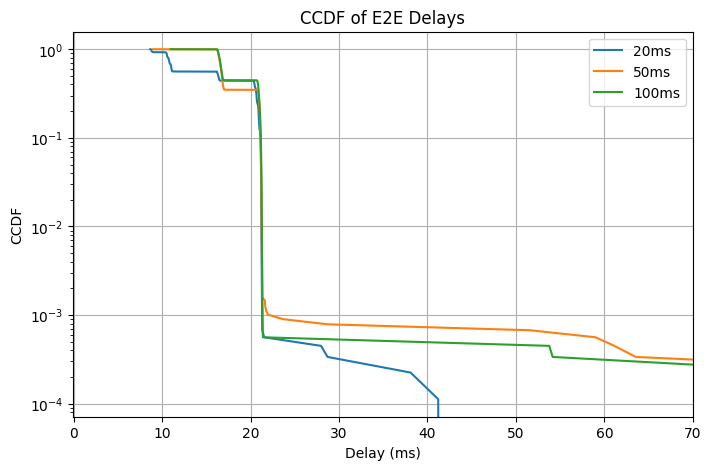

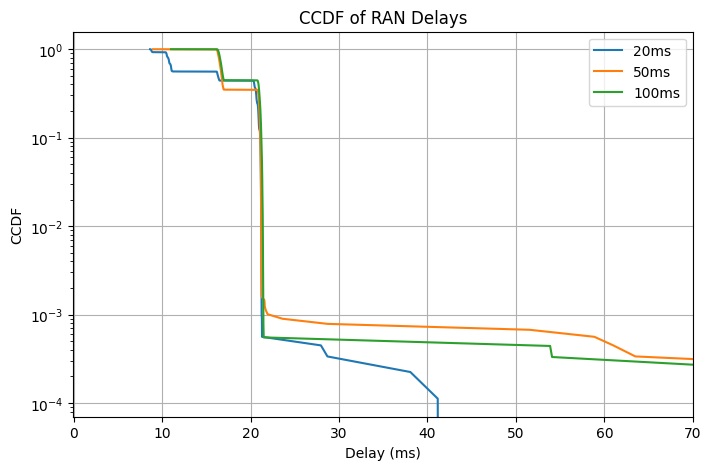

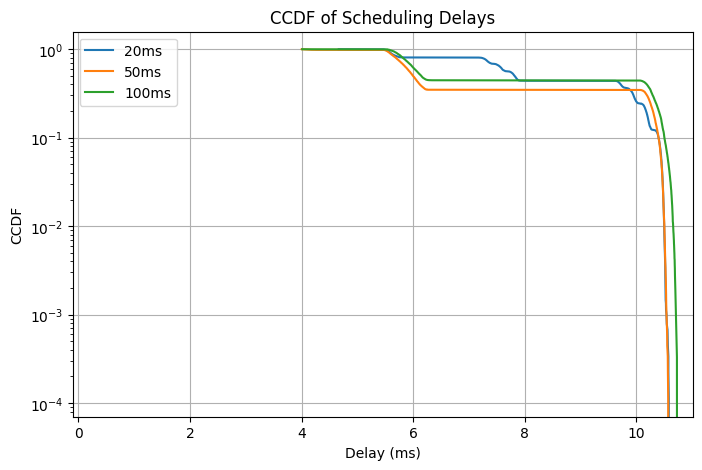

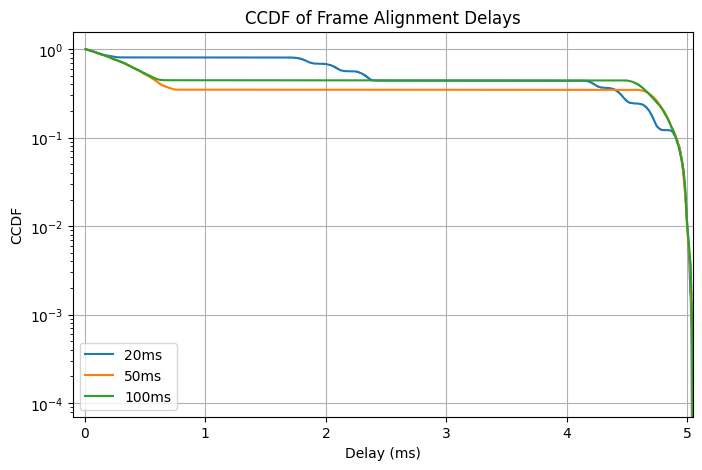

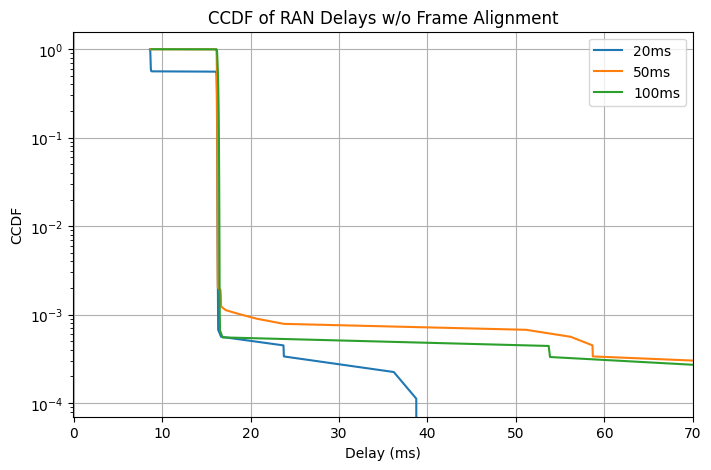

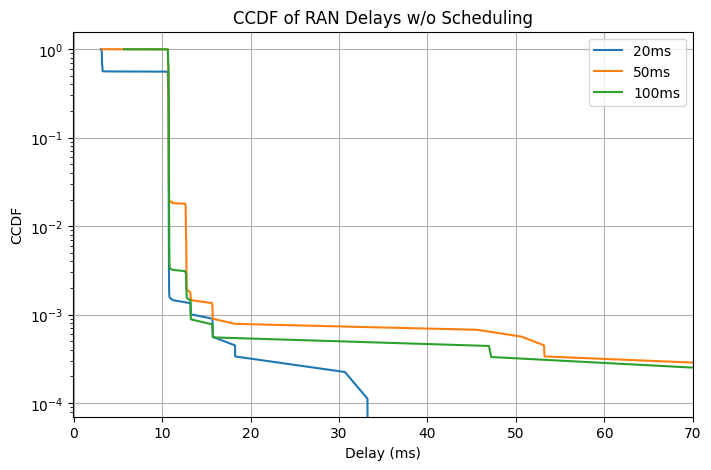

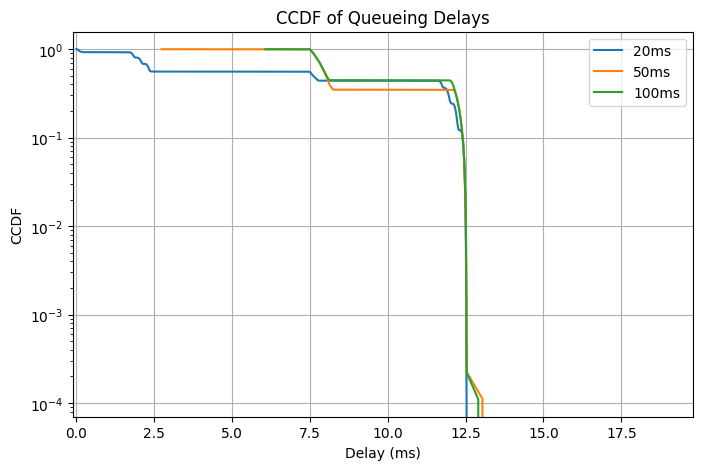

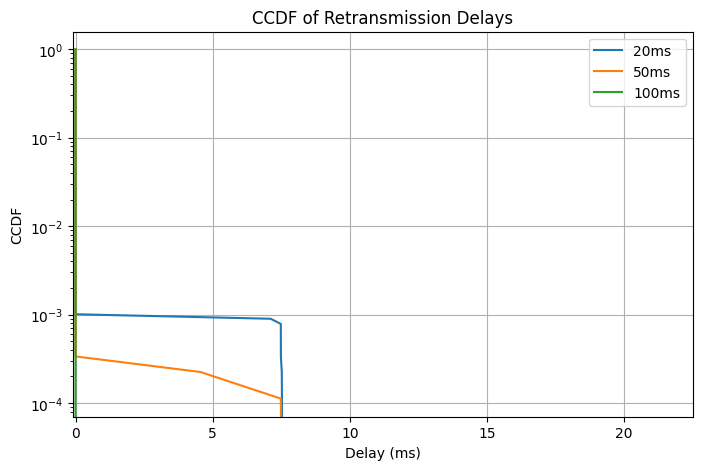

In [74]:
# Ensure the PLOTS_DIR exists
PLOTS_DIR = "./plots/combined/"
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

# Skip constants
SKIP_FIRST = 1000
SKIP_LAST = 100

# Initialize lists to store delay data from all DB files for each delay type
e2e_delays_per_db = []
ran_delays_per_db = []
scheduling_delays_per_db = []
frame_alignment_delays_per_db = []
ran_delays_wo_frame_alignment_delay_per_db = []
ran_delays_wo_scheduling_delay_per_db = []
queueing_delays_per_db = []
retx_delays_per_db = []

# Collect delay data from each DB file
for idx, delays in enumerate(delays_data):
    e2e_delays_per_db.append(delays['e2e_delays'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_per_db.append(delays['ran_delays'][SKIP_FIRST:-SKIP_LAST])
    scheduling_delays_per_db.append(delays['scheduling_delays'][SKIP_FIRST:-SKIP_LAST])
    frame_alignment_delays_per_db.append(delays['frame_alignment_delays'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_wo_frame_alignment_delay_per_db.append(delays['ran_delays_wo_frame_alignment_delay'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_wo_scheduling_delay_per_db.append(delays['ran_delays_wo_scheduling_delay'][SKIP_FIRST:-SKIP_LAST])
    queueing_delays_per_db.append(delays['queueing_delays'][SKIP_FIRST:-SKIP_LAST])
    retx_delays_per_db.append(delays['retx_delays'][SKIP_FIRST:-SKIP_LAST])

# Plot E2E Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(e2e_delays_per_db, 'E2E Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}e2e_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot RAN Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_per_db, 'RAN Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Scheduling Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(scheduling_delays_per_db, 'Scheduling Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}scheduling_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Frame Alignment Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(frame_alignment_delays_per_db, 'Frame Alignment Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}frame_alignment_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot RAN Delays w/o Frame Alignment for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_wo_frame_alignment_delay_per_db, 'RAN Delays w/o Frame Alignment', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot RAN Delays w/o Scheduling for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_wo_scheduling_delay_per_db, 'RAN Delays w/o Scheduling', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_scheduling_delay_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Queueing Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(queueing_delays_per_db, 'Queueing Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}queueing_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Retransmission Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(retx_delays_per_db, 'Retransmission Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}retx_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

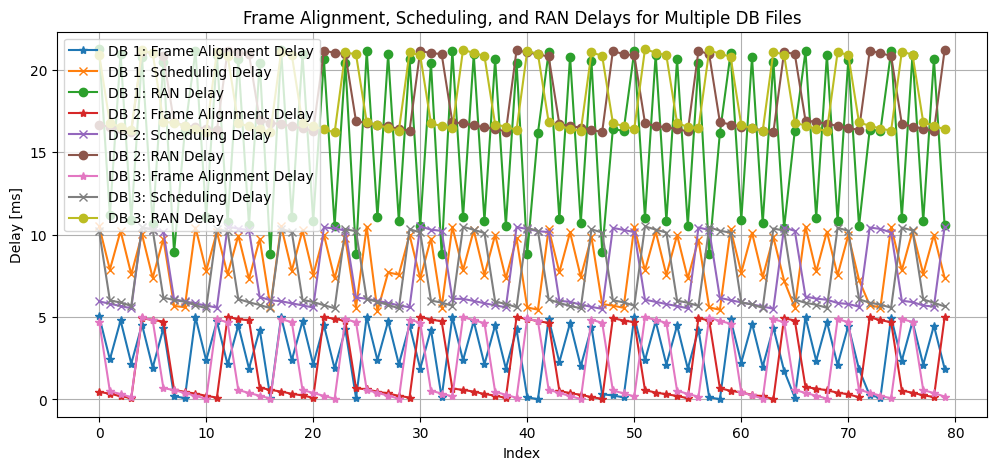

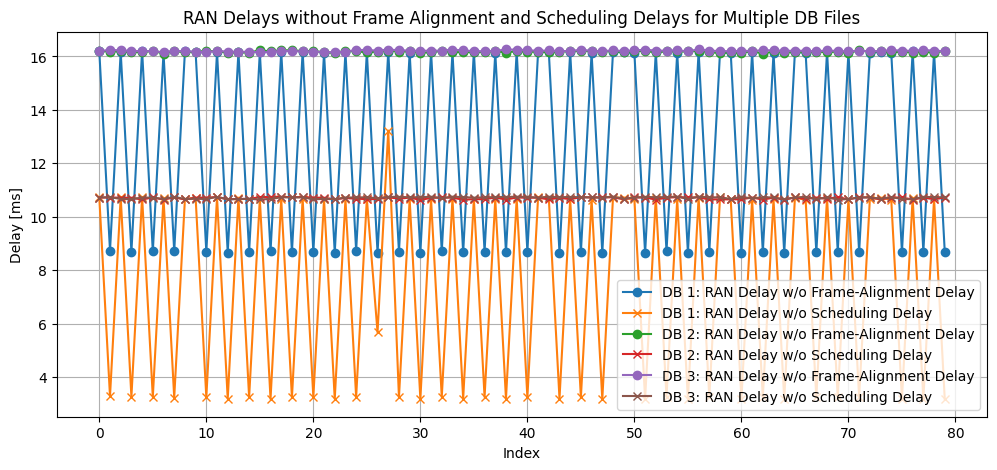

In [75]:
# Index range and skip constants
index_range = slice(1000, 1080)
SKIP_FIRST = 1000
SKIP_LAST = 100

# Create a figure and axes for frame alignment, scheduling, and RAN delays
fig, ax = plt.subplots(figsize=(12, 5))

# Plot delays for all DB files on the same axis
for idx, delays in enumerate(delays_data):
    # Extract delays for the current DB_FILE
    frame_alignment_delays = delays['frame_alignment_delays']
    scheduling_delays = delays['scheduling_delays']
    ran_delays = delays['ran_delays']
    
    # Plotting each data set with different markers and labels for each DB file
    ax.plot(frame_alignment_delays[index_range], marker='*', label=f'DB {idx+1}: Frame Alignment Delay')
    ax.plot(scheduling_delays[index_range], marker='x', label=f'DB {idx+1}: Scheduling Delay')
    ax.plot(ran_delays[index_range], marker='o', label=f'DB {idx+1}: RAN Delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')
ax.set_title('Frame Alignment, Scheduling, and RAN Delays for Multiple DB Files')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_timeseries_combined.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Create a figure and axes for RAN delay without frame alignment delay and scheduling delay
fig, ax = plt.subplots(figsize=(12, 5))

# Plot RAN delay without frame alignment and scheduling delays for all DB files on the same axis
for idx, delays in enumerate(delays_data):
    # Extract delays for the current DB_FILE
    frame_alignment_delays = delays['frame_alignment_delays']
    scheduling_delays = delays['scheduling_delays']
    ran_delays = delays['ran_delays']
    
    # Plotting each data set with different markers and labels for each DB file
    ax.plot(ran_delays[index_range] - frame_alignment_delays[index_range], marker='o', label=f'DB {idx+1}: RAN Delay w/o Frame-Alignment Delay')
    ax.plot(ran_delays[index_range] - scheduling_delays[index_range], marker='x', label=f'DB {idx+1}: RAN Delay w/o Scheduling Delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')
ax.set_title('RAN Delays without Frame Alignment and Scheduling Delays for Multiple DB Files')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_wo_scheduling_timeseries_combined.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

<class 'numpy.float64'>
[]


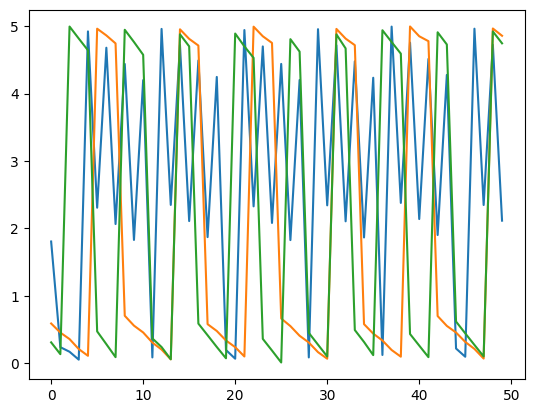

In [77]:
print(type(delays_data[2]['frame_alignment_delays'][20]))
plt.plot(delays_data[0]['frame_alignment_delays'][5000:5050])
plt.plot(delays_data[1]['frame_alignment_delays'][5000:5050])
#plt.plot(delays_data[1]['frame_alignment_delays'][index_range])
plt.plot(delays_data[2]['frame_alignment_delays'][5000:5050])
print([e for e in delays_data[0]['frame_alignment_delays'] if np.isnan(e)])

In [69]:
print(len(packets_list[0]))

10002
